# Evaluation metrics

* Detection metrics: precision, recall
* Segmentation metric: MCC

## Loading annotation & creating fake "prediction" image

In [1]:
import os
%pylab inline
from skimage.io import imread
import numpy as np

Populating the interactive namespace from numpy and matplotlib


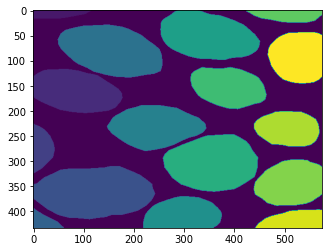

In [2]:
# Load annotation:
directory = "D:/Adrien/dataset/GlaS"
idx = 12
test_anno = imread(f'{os.path.join(directory, "train")}/train_{idx}_anno.bmp')

plt.figure()
plt.imshow(test_anno)
plt.show()

Creating a fake "prediction" by removing some objects, adding some objects, and deforming everything a bit:

In [60]:
test_prediction = test_anno.copy()

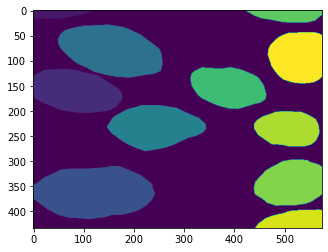

In [61]:
# Remove some objects
to_remove = np.random.randint(1,test_anno.max()+1,size=(5,))
for idobj in to_remove:
    test_prediction[test_anno==idobj] = 0
plt.figure()
plt.imshow(test_prediction)
plt.show()

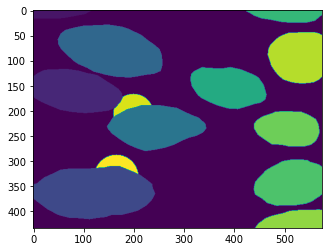

In [62]:
# Add some objects
from skimage.morphology import disk
max_radius = 50
obj_params = np.random.random((3,3))
for param in obj_params:
    obj = disk(int(param[0]*max_radius))
    topleft = (int(param[1]*(test_anno.shape[0]-obj.shape[0])),int(param[2]*(test_anno.shape[1]-obj.shape[1])))
    region = test_prediction[topleft[0]:topleft[0]+obj.shape[0], topleft[1]:topleft[1]+obj.shape[1]]
    region[region==0] = obj[region==0]*(test_prediction.max()+1)
plt.figure()
plt.imshow(test_prediction)
plt.show()

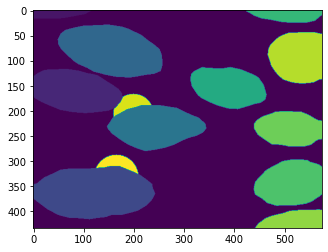

In [63]:
# Random deformations
from skimage.morphology import opening,closing

for idobj in np.unique(test_prediction[test_prediction>0]):
    obj = test_prediction==idobj
    print(idobj, end='\r')
    r = np.random.randint(-40, 40)
    if r < 0:
        obj = opening(obj, disk(-r))
    else:
        obj = closing(obj, disk(r))
    test_prediction[obj] = idobj

plt.figure()
plt.imshow(test_prediction)
plt.show()

## Implementing GlaS challenge detection metric

(Adapted from Matlab code released by the challenge organizers: https://warwick.ac.uk/fac/cross_fac/tia/data/glascontest/evaluation/)

Quoting the challenge website: 

"The ground truth for each segmented object is the object in the manual annotation that has maximum overlap with that segmented object.

A segmented glandular object that intersects with at least 50% of its ground truth will be considered as true positive, otherwise it will be considered as false positive. A ground truth glandular object that has no corresponding segmented object or has less than 50% of its area overlapped by its corresponding segmented object will be considered as false negative."

**To keep a bit more information, we make the function return the precision & recall rather than the F1-score.**

In [64]:
gt_labels = test_anno.copy()
pred_labels = test_prediction.copy()

# Get unique labels in prediction and ground truth:
trueLabels = np.unique(gt_labels)
trueLabels = trueLabels[trueLabels>0].astype('int')
predLabels = np.unique(pred_labels)
predLabels = predLabels[predLabels>0].astype('int')
print(trueLabels)
print(predLabels)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 1  2  4  6  7 11 12 13 14 15 16 17 18]


In [65]:
from scipy.stats import mode

# Find best matches for each segmented object:
best_matches = np.zeros((len(predLabels),3)) # predLabel, gtLabel, isValidMatch
best_matches[:,0] = predLabels
for i in range(len(predLabels)):
    predObject = pred_labels==predLabels[i] # select predicted object
    corrRegionInGT = gt_labels[predObject]  # find region in gt image
    if corrRegionInGT.max() > 0: # if it's only background, there's no match
        bestMatch = mode(corrRegionInGT[corrRegionInGT>0])[0][0]  # mode of the region = object with largest overlap
        matchInGT = gt_labels==bestMatch    # Select GT object 
        best_matches[i,1] = bestMatch       
        overlap = predObject*matchInGT      # Select overlapping region
        best_matches[i,2] = (overlap.sum()/matchInGT.sum())>0.5 # if #overlapping pixels > 50% GT object pixels : valid

print(best_matches)

[[ 1.  1.  1.]
 [ 2.  2.  1.]
 [ 4.  4.  1.]
 [ 6.  6.  1.]
 [ 7.  7.  1.]
 [11. 11.  1.]
 [12. 12.  1.]
 [13. 13.  1.]
 [14. 14.  1.]
 [15. 15.  1.]
 [16. 16.  1.]
 [17.  0.  0.]
 [18.  0.  0.]]


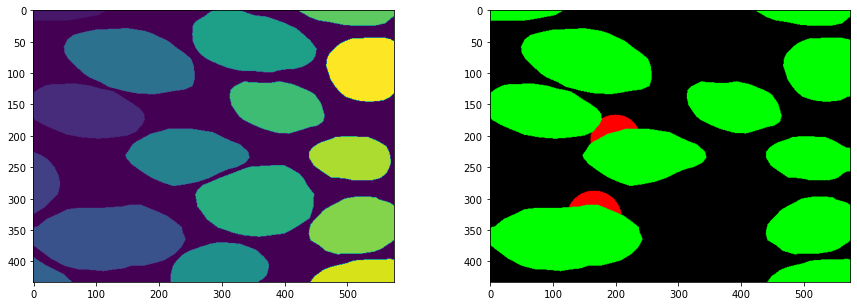

In [66]:
# Let's visually check that it's ok:
check_image = np.zeros(gt_labels.shape+(3,))
for match in best_matches:
    if( match[2]==1. ):
        check_image[pred_labels==match[1]] = np.array([0,1.,0]) # green = TP
    else:
        check_image[pred_labels==match[0]] = np.array([1.,0,0]) # red = FP
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(gt_labels)
plt.subplot(1,2,2)
plt.imshow(check_image)
plt.show()

In [67]:
# Compute TP/FP/FN
TP = int(best_matches[:,2].sum())
FP = int((best_matches[:,2]==0).sum())
FN = int(len(trueLabels)-TP)

print(TP, FP, FN)

11 2 5


In [72]:
# Compute precision & recall
precision = TP/(TP+FP)
recall = TP/(TP+FN)

print(f'Precision:\t{precision:.3f}')
print(f'Recall:\t\t{recall:.3f}')

Precision:	0.846
Recall:		0.688


## Implementing MCC segmentation metric

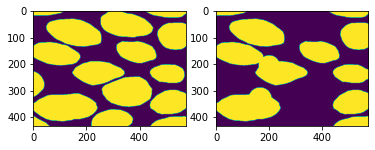

In [74]:
# Compute segmentation masks
gt_mask = gt_labels>0
pred_mask = pred_labels>0

plt.figure()
plt.subplot(1,2,1)
plt.imshow(gt_mask)
plt.subplot(1,2,2)
plt.imshow(pred_mask)
plt.show()

In [75]:
# Pixel-level TP, FP, FN, TN
TP = float(((gt_mask==True)*(pred_mask==True)).sum())
FP = float(((gt_mask==False)*(pred_mask==True)).sum())
FN = float(((gt_mask==True)*(pred_mask==False)).sum())
TN = float(((gt_mask==False)*(pred_mask==False)).sum())

In [77]:
# MCC
MCC = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
print(f'MCC:\t{MCC:.3f}')

MCC:	0.667
